# Simple Particle-in-cell Plasma Simulation 
___
### Movement of electrons  in an electric field

Things to add:

* 2D
* Magnetic field
* 

In [42]:
import numpy as np
import matplotlib.pyplot as plt

Generate particle initial positions

In [43]:
def initx(bc_particle):
    global dx, grid_length, rho0, npart, q_per_me, a0
    global charge, mass, wall_l, wall_r
    print("Load Particles")
    
    if (bc_particle >= 2):
        wall_l = dx / 2.
        wall_r = grid_length - 3 * dx / 2.
        plasma_i = wall_l
        plasma_f = wall_r
    
    else:
        plasma_i = 0.
        plasma_f = grid_length
        wall_l = 0.
        wall_r = grid_length

    xinit = plasma_f - plasma_i
    dpx = xinit / npart
    charge = -rho0*dpx
    mass = charge / q_per_me

    for i in range(npart):
        x[i] = plasma_i + dpx * (i + 0.5)
        x[i] += a0 * np.cos(x[i])  #perturbation

    return True

Generate particle initial velocities

In [44]:
def initv(idist,vte):
    global npart,v,grid_length,v0
    print("Set up velocity distribution")
        
    if (idist == 1):
        for i in range(npart):
            vm = vte*np.sqrt( (-2.*np.log((i+0.5)/npart)) ) 
            rs = np.random.random_sample() 
            theta = 2*np.pi*rs
            v[i] = vm*np.sin(theta) 
   
      # scramble particle indicies to remove correlations between x and v
        np.random.shuffle(v)
        
    else:
        v[1:npart] = 0.
        
    v += v0*np.sin(2*np.pi*x/grid_length)
    return True

Compute density

In [45]:
def density(bc_field,qe):
    global x,rhoe,rhoi,dx,npart,ngrid,wall_l,wall_r
    
    j1 = np.dtype(np.int32)
    j2 = np.dtype(np.int32)
    
    re = qe/dx
    rhoe = np.zeros(ngrid + 1)
    
    for i in range(npart):
        xa = x[i]/dx
        j1 = int(xa)
        j2 = j1 + 1
        f2 = xa - j1
        f1 = 1.0 - f2
        rhoe[j1] = rhoe[j1] + re*f1
        rhoe[j2] = rhoe[j2] + re*f2
        
    if (bc_field == 1): #periodic boundary conditions
        rhoe[0] += rhoe[ngrid]
        rhoe[ngrid] = rhoe[0]
        
    elif (bc_field == 2): #reflective boundary conditions - not working
        iwl = int(wall_l / dx)
        rhoe[iwl + 1] += rhoe[iwl]
        rhoe[iwl] = 0.0
        iwr = int(wall_r / dx)
        rhoe[iwr] += rhoe[iwr + 1]
        rhoe[iwr + 1] = rhoe[iwr]
        
    else:
         print("Invalid value for bc_field", bc_field)   
            
    rhoi = rho0
    
    return True

Compute electrostatic field

In [46]:
def field():
    global rhoe,rhoi,Ex,dx,ngrid
    
    rhot = rhoe + rhoi
    
    Ex[ngrid] = 0.
    edc = 0.0
    
    for j in range(ngrid-1, -1, -1):
        Ex[j] = Ex[j + 1] - 0.5*(rhot[j] + rhot[j + 1])*dx
        edc = edc + Ex[j]
        
    if (bc_field == 1): #boundary conditions = periodic
        Ex[0:ngrid] -= edc/ngrid
        Ex[ngrid] = Ex[0]
        
    return True

Particle movement

In [47]:
def push():  
    global x,v,Ex,dt,dx,npart,q_per_me

    for i in range(npart):
        xa = x[i]/dx
        j1 = int(xa)
        j2 = j1 + 1
        b2 = xa - j1
        b1 = 1.0 - b2
        exi = b1*Ex[j1] + b2*Ex[j2]
        v[i] = v[i] + q_per_me*dt*exi       

    
    x += dt*v     #Euler integration leap-frog
    
    return True

Check particle boundary conditions

In [48]:
def particle_bc(bc_particle,x1):
    global x
    
    for i in range(npart):
        if (x[i] < 0.0):
            x[i] += x1
        elif (x[i] >= x1):
            x[i] -= x1
    
    return True

Diagnostic outputs for fields and particles

In [49]:
def diagnostics():
    global rhoe,Ex,ngrid,itime,grid_length,rho0,a0
    global ukin,upot,utot,udrift,utherm,emax,fv,fm
    global iout,igraph,iphase,ivdist
    
    xgrid = dx * np.arange(ngrid + 1)
    
    if (itime == 0):
        plt.figure('fields')
        plt.clf()
    if (igraph > 0):
        if (np.fmod(itime,igraph) == 0):
        
        # Net Density
            plt.subplot(2, 2, 1)
            if (itime > 0):
                plt.cla()
            plt.plot(xgrid, -(rhoe + rho0),'r', label = 'density')
            plt.xlabel('x')
            plt.xlim(0,grid_length)
            #plt.ylim(-2*a0,2*a0)
            plt.legend(loc = 1)
            plt.draw()
            
        #Electric field
            plt.subplot(2, 2, 2)
            if (itime > 0):
                plt.cla()
            plt.plot(xgrid, Ex, 'b', label = 'Ex')
            plt.xlabel('x')
            plt.xlim(0,grid_length)
            #plt.ylim(-2*a0,2*a0)
            plt.legend(loc = 1)
            plt.draw()
            
        #Phase space
            if (iphase > 0):
                if (np.fmod(itime,iphase) == 0):
                    axScatter = plt.subplot(2, 2, 3)
                    if (itime > 0):
                        plt.cla()
                    axScatter.scatter(x,v,marker = '.', s = 1)
                    axScatter.set_xlim(0,grid_length)
                    #axScatter.set_ylim(-vmax,vmax)
                    axScatter.set_xlabel('x')
                    axScatter.set_ylabel('v')
                    plt.draw()
                    
        #Distribution function
            if (ivdist > 0):
                if (np.fmod(itime,ivdist) == 0):
                    fv = np.zeros(nvbin + 1)
                    dv = 2 * vmax / nvbin
                    
                    for i in range(npart):
                        vax = (v[i] + vmax) / dv
                        iv = int(vax) + 1
                        if (iv <= nvbin and iv > 0):
                            fv[iv] += 1
                            
                    plt.subplot(2, 2, 4)
                    if (itime > 0):
                        plt.cla()
                    vgrid = dv * np.arange(nvbin + 1) - vmax
                    plt.plot(vgrid,fv,'g',label='f(v)')
                    plt.xlabel('v')
                    plt.xlim(-vmax,vmax)
                    #plt.ylim(-5*a0,1000*a0)
                    plt.legend(loc = 1)
                    fn_vdist = 'vdist_%0*d'%(5, itime)
                    plt.draw()
                    
                    #np.savetxt(fn_vdist,np.column_stack((vgrid,fv)),fmt=('%1.4e','%1.4e'))
                    
            plt.pause(0.0001)
            plt.draw()
            filename = 'fields_%0*d'%(5, itime)
            if (iout > 0):
                if (np.fmod(itime,iout) == 0):
                    plt.savefig(filename+'.png')
                    
        #Kinetic energy
        v2 = v**2
        vdrift = sum(v) / npart
        ukin[itime] = 0.5*mass*sum(v2)
        udrift[itime] = 0.5*mass*vdrift*vdrift*npart
        utherm[itime] = ukin[itime] - udrift[itime]
        
        #Potential energy
        e2 = Ex**2
        upot[itime] = 0.5*dx*sum(e2)
        emax = max(Ex)
        
        #Total energy
        utot[itime] = upot[itime] + ukin[itime]
        
        return True

Plot time histories

In [50]:
def histories():
    global ukin, upot, utot, udrift, utherm
    
    xgrid = dt * np.arange(nsteps + 1)
    
    plt.figure('Energies')
    plt.plot(xgrid, upot, 'b', label = 'Upot')
    plt.plot(xgrid, ukin, 'r', label = 'Ukin')
    plt.plot(xgrid, utot, 'black', label = 'Utot')
    plt.xlabel('t')
    plt.ylabel('Energy')
    #plt.ylim(0.0,1.0)
    
    plt.legend(loc = 1)
    plt.savefig('energies.png')
    
    np.savetxt('energies.out', np.column_stack((xgrid,upot,ukin,utot)),fmt = ('%1.4e','%1.4e','%1.4e','%1.4e'))

Main program

In [51]:
npart = 50000 #number of particles
ngrid = 8000 #number of grid points
nsteps = 360 #time steps

#particle arrays
x = np.zeros(npart)
v = np.zeros(npart)

#grid arrays
rhoe = np.zeros(ngrid + 1) #electron density
rhoi = np.zeros(ngrid + 1) #ion density
Ex = np.zeros(ngrid + 1) #electric field
phi = np.zeros(ngrid + 1) #potential

#time histories
ukin = np.zeros(nsteps + 1)
upot = np.zeros(nsteps + 1)
utherm = np.zeros(nsteps + 1)
udrift = np.zeros(nsteps + 1)
utot = np.zeros(nsteps + 1)

Define main variables and defaults

In [52]:
grid_length = 16.0 * np.pi #size of spatial grid
plasma_i = 0.
plasma_f = grid_length
dx = grid_length/ngrid
dt = 0.01 #normalized timestep
q_per_me = -1.0 #electron charge to mass ratio
rho0 = 1.0 #background ion density
vte = 0.02 #thermal velocity E dominant < ~0.068 < T dominant
nvbin = 200 #bins for nv plot
a0 = 0.1 #perturbation amplitude
vmax = 0.1 #max vel for nv plot
v0 = 0.00 #velocity perturbation
wall_l = 0.
wall_r = 2.
bc_field = 1
bc_particle = 1
profile = 1
distribution = 1 #vel distribution, 1 = thermal else = cold; stream not implem
ihist = 1 #freq of time-history output
igraph = int(np.pi/dt/24) #freq of graphical snapshots
iphase = igraph
ivdist = igraph
iout = igraph
itime = 0 #initialize time counter

Setup initial particle distribution and field states

Load Particles
Set up velocity distribution


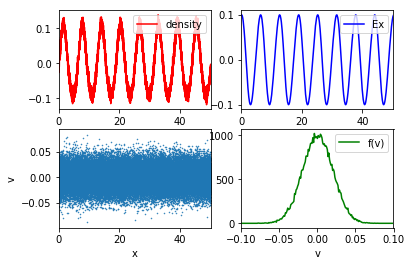

Resolution dx/lambda_D= 0.3141592653589793


<Figure size 432x288 with 0 Axes>

In [53]:
initx(bc_particle)
initv(distribution,vte)
x += 0.5*dt*v
particle_bc(bc_particle,grid_length)
density(bc_field,charge)
field()
diagnostics()
print('Resolution dx/lambda_D=',dx/vte)

Iteration loop

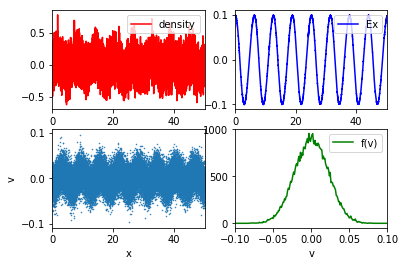

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [54]:
for itime in range(1,nsteps + 1):
    #print('timestep ',itime)
    push() #push particles
    particle_bc(bc_particle,grid_length) #enforce boundary conditions
    density(bc_field,charge) #compute density
    field() #compute electric field
    diagnostics() #output snapshots and time histories
    
histories()

print('Done')

### References

1. P. Gibbon, KU-Leuven & FZ-Juelich. ESPIC: a simple 1D1V electrostatic PIC code, November 2013: https://indico.cern.ch/event/285444/contributions/1636921/attachments/528868/729185/espic.py
  